# Data Cleaning -  USD/EUR 40years
- builds 4D tensor with GADF features

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3 as sql
import pickle
import import_ipynb # pip install import-ipynb
#from toolbox import * # helper functions 

#### Raw Price Data 

In [5]:
l = []
for f in range(1,4):
    l.append(pd.read_csv("usd_eur_40yrs/%s.csv"%(f),
                     na_filter=True,
                     parse_dates=True,
                     index_col="Date",
                    ))
# merge 10year csvs
df = pd.concat(l,axis=0)
# sort by date
df.sort_values(["Date"],inplace=True)
# needless feature
df.drop("Change %",axis=1,inplace=True)
print (df.shape)
df.head()

(7672, 4)


,Price,Open,High,Low
Date,,,,
1980-01-02,0.6601,0.6601,0.6601,0.6601
1980-01-03,0.6589,0.6589,0.6589,0.6589
1980-01-04,0.6610,0.6610,0.6610,0.6610
1980-01-07,0.6593,0.6593,0.6593,0.6593
1980-01-08,0.6619,0.6619,0.6619,0.6619


In [6]:
# Save to database
conn = sql.connect('database.db')
cur = conn.cursor()
df.to_sql("raw_prices", conn, if_exists="replace")
conn.close()

## Section for TA indicators (Future)

- No volume in dataset

## Create GAF images
- apply a 5day rolling window to create 1day step labels for supervised learning 
- independent variables for training set:  Open, High, Low
- dependent variable: Price
- 80-20 train/test split
- **Just 2 classes B/S** 

In [7]:
from mpl_toolkits.axes_grid1 import ImageGrid
from pyts.image import GramianAngularField # conda install -c conda-forge pyts

# Parameters
path = 'database.db'
table_name = 'raw_prices'
n_steps = 10 # 5 day rolling window 
split_threshold = 0.80 # 80-20 train-test split
transaction_threshold = 1 # Transaction cost per trade as a % ( 1 = 1 %)

#### Creating Labels 

In [8]:
# Retrieve raw prices
conn = sql.connect(path)
cur = conn.cursor()
df = pd.read_sql_query("SELECT Date,Price, Open, High, Low FROM %s" %(table_name), conn)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index(['Date'],inplace=True)

# Create labels for supervised learning
df_classes = pd.DataFrame()
df_classes["t"] = df['Price']
df_classes["t+1"] = df['Price'].shift(1); df_classes["t+1"][0] = 0.6601 # fill original val
df_classes["class"] = 0
df_classes["class"].where(df_classes["t"].values>df_classes["t+1"].values,
                          1, # if price rise -> BUY , else -> SELL
                          inplace=True,  )
print(df_classes.head(2))
# Save labels to database
df_classes.to_sql("classes", conn, if_exists="replace")
conn.close()

# Set as new feature in df
df['Class'] = df_classes["class"].values

                 t     t+1  class
Date                             
1980-01-02  0.6601  0.6601      1
1980-01-03  0.6589  0.6601      1


#### Creating poolar encodings

In [12]:
# Split into train / test sets
df_train = df.iloc[ : int(len(df) * split_threshold), : ]
df_test = df.iloc[int(len(df) * split_threshold) : , : ]
print (df_train.shape, df_test.shape)

"""
Inputs: independent non-categorical features. (All price data)
Ouputs: Polar coordinates
- Scales independent features 0-1 with MinMax
- Uses arccos to create polar coordinates  for the subsequent GASF images
"""
def scale_and_polarise(train_data,test_data):
    # def prep_data
    " Scale data between [ 0 , 1 ] with MinMax  "
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    #scaler2 = MinMaxScaler()

    scaled_train = scaler.fit_transform(train_data)
    #scaled_test= scaler2.fit_transform(test_data)
    scaled_test= scaler.transform(test_data)
    #print(np.max(scaled_train) , np.max(scaled_test)) # sanity check

    " Encode angles as Polar Coordinates  "
    polar_train = pd.DataFrame(np.arccos(scaled_train))
    polar_test = pd.DataFrame(np.arccos(scaled_test))
    #print(np.max(polar_train) , np.max(polar_test)) # sanity check
    
    # Set column names and index as in original
    polar_train.columns = train_data.columns ; polar_test.columns = test_data.columns
    polar_train.index = train_data.index ; polar_test.index = test_data.index
    
    # save the scaler for future use 
    pickle.dump(scaler, open('../trained_models/scaler.pkl', 'wb'))
    
    return polar_train, polar_test

# Create Polar Coordinates forfrom independent features ( except dependent / categorical )
polar_train, polar_test = scale_and_polarise(df_train.loc[:,df_train.columns != "Class"],
                                                        df_test.loc[:, df_test.columns != "Class"],   )
tranformed_train, tranformed_test = pd.concat([polar_train, df_train['Class'],], axis=1), pd.concat([polar_test, df_test['Class'],], axis=1)

(6137, 5) (1535, 5)


#### Creating Training / Test data

In [7]:
"""
Inputs: time-series from data subset
Ouputs: training data & labels 
- Divides series into independent and dependent features 
- So that it can create training data and labels 
- Based on length of rolling window, and how many steps ahead the forecast is 
- **Loss of data** equal to size of window
"""
def split_series(df, n_steps):
    features_indi = df.loc[:, df.columns != 'Class'].to_numpy() # exlude dependent feature
    features_depe = df['Class'].to_numpy()
    X, y = list(), list()
    for i in range(len(df)):
        end_ix = i + n_steps # find the end of this pattern
        if end_ix > len(df)-1: # check if we are beyond the dataset
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = features_indi[i:end_ix, :], features_depe[end_ix] 
        X.append(seq_x) ; y.append(seq_y)
        
    return np.array(X), np.array(y), pd.DataFrame(df.index[n_steps:])#dates - rolling window

# Split each of the train / test sets into training data and labels ( Data loss = size rolling window)
trainX, trainY, train_dates = split_series(tranformed_train,n_steps)
testX, testY, test_dates = split_series(tranformed_test,n_steps)


" FOR 1 SECURITY MAY NOT BE NEEDED "
# # Expand Dimensions 
# """
# CORRECT FORMAT: samples(datapoints),rows(window),columns(stocks),channels(features) 
# - for cnn
# """
# trainX = np.expand_dims(trainX,axis=2); testX = np.expand_dims(testX,axis=2) # for features
# trainY = np.expand_dims(trainY,axis=1); testY = np.expand_dims(testY,axis=1) # for labels

# Check resulting shape of tensor
[x.shape for x in [trainX, trainY, train_dates, testX, testY, test_dates ]]

[(6127, 10, 4), (6127,), (6127, 1), (1525, 10, 4), (1525,), (1525, 1)]

#### Creating GAF features

In [8]:
def feature_tensor2GAF (ndarray, n_steps):
    """
    Pass each stock in nd array,
    - creates a 4D array
    - For period t creates 3 images of size 10*10 for each of the 3 features
    - need to create a 5d array for a portfolio 
    """
    # accepts a DF 
    ## loops over Stocks creating GSF time series
    list_features = []
    for feature in range(ndarray.shape[2]): 
        transformer = GramianAngularField(image_size=n_steps, method='summation') # ==> MAKES THEM INTO IMAGES
                                                                             # image_size must be equal to window lentgh
        transformed_feature = transformer.transform(ndarray[:,:,feature]) # these are the features 
        list_features.append(transformed_feature)
        
    return np.transpose((list_features), axes=(1,2,3,0)) #np.array(list_features) #np.transpose((list_features), axes=(1,0,2,3)) #axes=(1,2,3,0)

In [9]:
# Convert independent variables into GAF features from train and test sets
train_X = feature_tensor2GAF(trainX, n_steps)
test_X = feature_tensor2GAF(testX, n_steps)
# Rename labels
train_Y, test_Y = trainY, testY

[x.shape for x in [train_X, train_Y, test_X, test_Y]]

[(6127, 10, 10, 4), (6127,), (1525, 10, 10, 4), (1525,)]

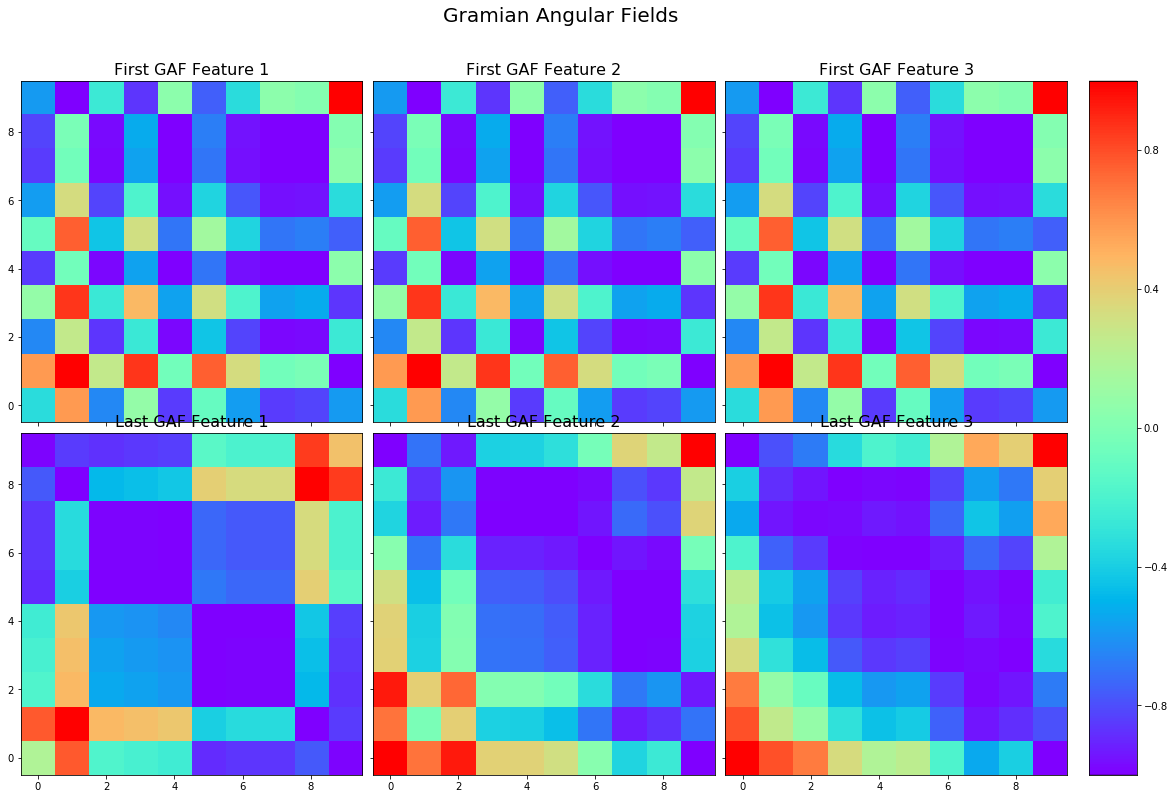

In [10]:
train_gaf_3d = train_X # Data only for USD/EUR
fig = plt.figure(figsize=(20, 14))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(2, 3),
                 axes_pad=0.15,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="7%",
                 cbar_pad=0.3)

images = [train_gaf_3d[0,  : , :, 0],
          train_gaf_3d[0,  : , :, 1],
          train_gaf_3d[0,  :, :, 2],
          train_gaf_3d[-1,  : , :, 0],
          train_gaf_3d[-1,  : , :, 1],
          train_gaf_3d[-1,  : , :, 2] ]   # 3 first stock features, last image
 
titles = ['First GAF Feature 1','First GAF Feature 2','First GAF Feature 3',
          'Last GAF Feature 1','Last GAF Feature 2', 'Last GAF Feature 3']

for image, title, ax in zip(images, titles, grid):
    im = ax.imshow(image, cmap='rainbow', origin='lower')
    ax.set_title(title, fontdict={'fontsize': 16})
ax.cax.colorbar(im)
ax.cax.toggle_label(True)

plt.suptitle('Gramian Angular Fields', y=0.92, fontsize=20)
plt.show()

#### Save GAF Features for modeling

In [11]:
''' 
4D tensor 
GADF 
10 rolling window
1 step ahead forecast
'''
file = open('usd_eur_gadf.pkl', 'wb')
pickle.dump( # dump information to that file
    [train_X,train_Y,train_dates, # TRAIN DATA
     test_X,test_Y, test_dates  # TEST DATA
    ],  file)
file.close()

============================  END  ===========================